#### This module will house the functions and code where we run models and try to get the highest R^squared/lowest RMSLE

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.reset_defaults()

### Model Rationale and Project Trajectory

As elaborated in the introduction, we picked crime data because crime and murder prediction is an important problem to solve. An algorithm that can predict future murder can be a huge asset to state and local governments.Ultimately, we focused on trying to predict the most recent year, and thus chose 2016 to be our test set.

Next, we chose models. We decided to cross validate and tune hyper parameters on regression models that we used in this class: **Lasso, Ridge, Random Forest, and Graident Boosting.** However, we needed a baseline for model comparison. 

<u> Baseline </u>

We chose a simple **auto-regressive model** to service as our baseline. For year t,


 $$ Murder_t = B_0 + B_1 Murder_{t-1} $$


<u> Features </u>

We decided to use all of the features which met the imputation threshold (*see Data Sources Page for details*). This included crime variables, census variables, GDP, one-hot encoded State, MSA and year variables. We will let regularization and tree methods select the features that are most important.  **The only features that we drop are those that are transformations/related to murder: murder rate, number of violent crimes (since it is the sum of murder and all the other crime variables), city murder, violent crime rate, and city violent crime.**


<u> Use of Lags</u>

We decided to include the previous year's number of murders as a feature. This is standard in time series prediction, but it makes sense for us to have to eliminate 2006, so our training set becomes 2007-2015.
 
<u> Metrics </u>
 
In order to compare models, we need a metric. We decided not to use R<sup>2</sup> after realizing that it was inappropriate. Without any effort, we were getting extremely high R<sup>2</sup> and this is because TSS (Total Sum of Squares Error) will be extremely high as it pulls a mean out of the entire sample which will vary widely by MSA. Instead we chose to compare MSE. As a result, the ratio of between RSS and TSS will very low and R<sup>2</sup> will be very high. Instead, we chose to compare model performance using mean squared error on the test set. 
 
<u> Hyper-parameter tuning </u>
 
Lasso/Ridge - We cross-validated on the regularization parameter.  Note that we tried to perform scaling (standardization and normalization) but this resulted in inferior performance. This was due to the fact that distribution on train and test data was not the same which was leading to extremely poor performance on the transformed test set, so we chose to cross validate without standardizing/normalizing. However, we recognize that this made interpreting coefficients much more difficult as the features had different scales.

Random Forest - We cross-validated on the number of trees. Additionally, we set the bootstrap parameter false as we did not feel that bootstrapping was valid in the time series context.  Additionally, because we didn’t have a wide variety of features that were correlated with murder, we set max features equal to the number of features. This resulted in more correlated trees, but avoids trees constructed solely with poor features.

Gradient Boosting - Any deviations in learning rate from 0.1 resulted in horrendous performance. So we fixed learning rate and cross validated on the depth of each tree used during boosting.

 
 <u> Cross Validation Strategy </u> 
 
Because we were interested in using past data to predict future data, we couldn’t use a simple train-test split. Instead, we implemented a rolling window cross validation strategy. This is a time-series variation of leave one out cross validation. In this iterative approach you increase the training set by one year each iteration and your validation window rolls back in time.

In our context, this would mean training on 2007, validating on 2008-2015 in the first iteration, training on 2007-2008, validating on 2009-2015 in the following iteration and taking the average of each validation error at the end.

However, since our focus is to predict the most recent year, we modified the rolling window. We restricted the validation set to only be a single year, and we set our validation window range to be  2010-2015. We do this to help simulate our goal which is to use preceding data to predict the most recent year.

So, our modified rolling window was: Train on 2007-2009 Validate on 2010 Train on 2008-2010 Validate on 2011 etc
For model above, we picked the parameter that gave the lowest average validation MSE. We then fit that model on the entire training set and recorded the MSE on the test set predictions.

 
 <u> Do early years matter? </u>
 
 Finally, we also wanted to test whether earlier years (ie 2007, 2008) matter when it comes to predicting 2016. So, we ran a loop that increased the first year of training each iteration. This table illustrates the first two iterations.


|          Iteration          | Training Set Range|
|--------------------------------|----------------------------------------------------------------------|
| 1 |2007 - 2015
| 2 |2008 - 2015


Within each loop we found the optimal parameter using rolling window cross validation, fitted the model on the restricted training set year range using that best model and reported test set performance. This allowed us to compare models within each training set range and see how models performed using different training set ranges, which was one of our goals of this project. 

In [2]:
#Import Data
final_df= pd.read_json('output/final_imputed1.json')
final_df = final_df.sort_values(['join_key', 'year'])

In [3]:
# Adding Lag murer_mans
final_df['lag_y'] = final_df.groupby(['join_key'])['mur_mans'].shift(1)
final_df = final_df.loc[final_df.year >= 2007, :]

In [4]:
# Don't need these variables for modeling - strings and murder derivatives
no_model_vars = ['violent_crime', 'rate_mur_mans', 'rate_violent_crime', 
                 'city_violent_crime', 'city_mur_mans','mur_mans','state_key',
                 'join_key','MSA','largest_city','city_key']

In [5]:
# Test Set will be 2016
final_two = final_df['year'].isin([2016])
# Need year for indexing but don't put into model
x_vars = final_df.columns.difference(no_model_vars)
model_vars = [x for x in x_vars if x != 'year']

y_var = 'mur_mans'
xtrain = final_df.loc[~final_two, x_vars]
ytrain = final_df.loc[~final_two, y_var]

xtest = final_df.loc[final_two, x_vars]
ytest = final_df.loc[final_two, y_var]

#### Baseline Model -  Simple Auto-regressive Model

In [6]:
# Autoregressive model
lin_reg = LinearRegression()
auto_reg_results = []
for y in range(2006, 2014):
    lin_reg.fit(xtrain.loc[xtrain.year > y, ['lag_y']].values, ytrain[xtrain.year > y])
    auto_reg_results.append(mean_squared_error(ytest, 
                                               lin_reg.predict(xtest.loc[:, ['lag_y']].values)))

In [7]:
'''
Function
----------
hyper_tuning

This function will control which parameters we tune for each one
of our regressor model. It takes in a string for model type and parameter
and returns a model with that parameter set.

Parameters

model_type (str)  - "LASSO", "RIDGE", "RF", "GB"
param (float) - number for hyper parameter
'''
def hyper_tuning(model_type, param):
    if model_type == "LASSO":
        m = Lasso(alpha=param)
    elif model_type == "RIDGE":
        m = Ridge(alpha=param)
    elif model_type == "RF":
        m = RandomForestRegressor(n_estimators=param, bootstrap=False)
    elif model_type == "GB":
        m = GradientBoostingRegressor(max_depth =param)
    else:
        print("Model type incorrectly specified")
    return(m)


'''
Function
-------------
Rolling_later
 
This funciton implements a variation on rolling window cross validation. It does cross validation where the validation set is always one year and always between 2010-2015. If provided min_year > 2010, the validation set is always between min_year and 2015 (when training set is 2012-2015 for example)
 
Parameters:
 
Model_type (str) - "LASSO", "RIDGE", "RF", "GB"
param_list - list of floats to feed into model
xtrain - dataframe or matrix of features
ytrain - response variable vector
min_year - first year of training set

Returns parameter that gave lowest mean squared validation error
'''
def rolling_later(model_type, param_list, xtrain, ytrain, min_year):

    errors = []
    for p in param_list:
        m = hyper_tuning(model_type, p)
        # Capture average cross validation error for this parameter
        p_errors = []
        min_year = xtrain['year'].min()
        # If train set has thrown out 2010 we want 2011 to be starting validation
        if min_year >= 2010:
            start_val = min_year + 1
        else:
            start_val = 2010
        
        for yr in range(start_val, 2015):
            val_index = xtrain.year == yr
            tr_index  = xtrain.year < yr
            
            xtr = xtrain.loc[tr_index, model_vars]
            ytr = ytrain[tr_index]
            
            xval = xtrain.loc[val_index, model_vars]
            yval = ytrain[val_index]
            
            m.fit(xtr, ytr)
            # We are going to return error divided by number of years in Val window
            # This will put more weight when validation is later and fewer years
            p_errors.append(mean_squared_error(yval, m.predict(xval)))
        # For this parameter store the average error
        errors.append(np.mean(np.mean(p_errors)))
    # Next I need return the best parameter
    return(param_list[np.argmax(errors)])

In [8]:
# Quick Function to get mse
mse = lambda m: mean_squared_error(ytest, m.predict(xtest.loc[:, model_vars]))

In [9]:
# This function is going to final optimal parameter for each
# one of our regression model and store it. It will do
# this 6 times each each time we drop all variables <= y
# in below loop
# we are going to try to see if we get performance only
# using more recent data
param_vectors = {"LASSO": [0.1, 0.5, 1, 2, 5], 
                 'RIDGE': [x for x in range(1, 10)], 
                 'RF': [100, 200, 250], 
                 'GB': [1,2,3]}
test_errors = {"LASSO":[] , 'RIDGE': [] , 'RF': [], 'GB': []}
best_params = {"LASSO":[], "RIDGE":[], "RF":[], "GB":[]}
for min_year in range(2007, 2015):
    print("Dropping %i" %(min_year - 1))
    # Keep min_year and above
    # first iteration 2006-
    # secon iteration 2007-
    drop_y = final_df.year >= min_year
    xtrain_drop = final_df.loc[(~final_two) & (drop_y), x_vars]
    ytrain_drop = final_df.loc[(~final_two) & (drop_y), y_var]
    # Now Cross Validate on this year range using Rolling Window
    # to final optimal paramter from dictionary above
    for model in param_vectors.keys():
        best_param = rolling_later(model, 
                                   param_vectors[model],
                                   xtrain_drop,
                                   ytrain_drop,
                                   min_year) 
        best_params[model].append(best_param)
        best_m = hyper_tuning(model, best_param)
        # Now fit on training set with certain years dropped and predict on the test
        best_m.fit(xtrain_drop.loc[:, model_vars], ytrain_drop)
        test_errors[model].append(mse(best_m))

Dropping 2006
Dropping 2007
Dropping 2008
Dropping 2009
Dropping 2010
Dropping 2011
Dropping 2012
Dropping 2013


### This plot looks at different models performance on test set as a function of first year of training data

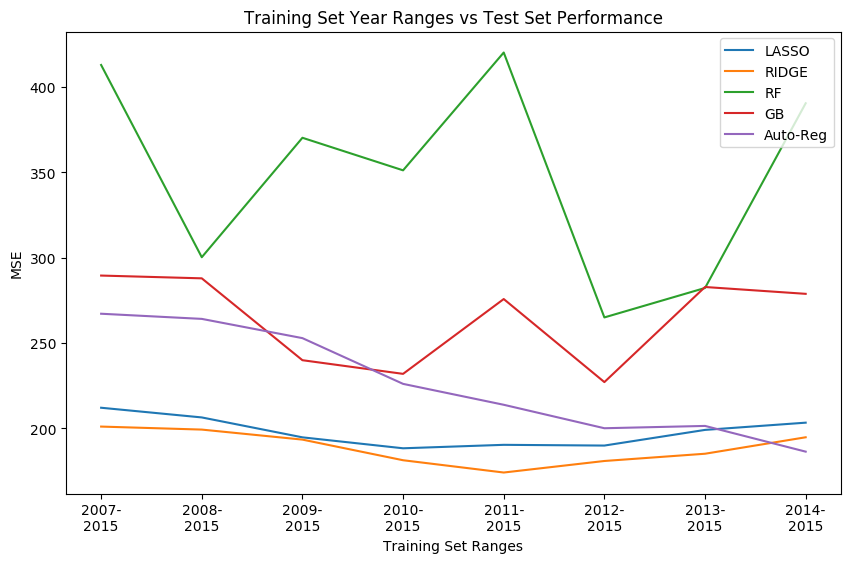

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
for k in test_errors.keys():
    ax.plot(test_errors[k], label=k)
# Plot Auto Regressive
ax.plot(auto_reg_results, label="Auto-Reg")

ax.set_title("Training Set Year Ranges vs Test Set Performance")
ax.set_xlabel("Training Set Ranges")
ax.set_ylabel("MSE")
ax.set_xticks(np.arange(8))
xlabels=['2007-\n2015', '2008-\n2015', '2009-\n2015',
         '2010-\n2015', '2011-\n2015', '2012-\n2015',
         '2013-\n2015', '2014-\n2015']
ax.set_xticklabels(xlabels)
ax.legend(loc='best')
plt.show()

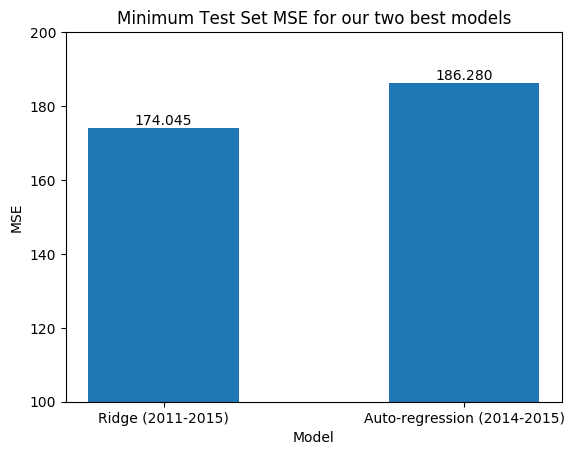

In [12]:
bar_errors = [np.min(test_errors['RIDGE']), 
              np.min(auto_reg_results)]
num_bars = np.arange(2)
plt.bar(num_bars, bar_errors, width=0.5)
plt.ylabel("MSE")
plt.xlabel("Model")
plt.xticks(num_bars, ['Ridge (2011-2015)', 'Auto-regression (2014-2015)'])
plt.title('Minimum Test Set MSE for our two best models')
plt.ylim(100, 200)
for x, height in enumerate(bar_errors):
    plt.text(x, height, '%0.3f' %height, ha='center', va='bottom')
plt.show()